# 使用NEU-DET練習影像分類，遷移學習

### 匯入函式庫

In [1]:
#匯入函式庫，數值矩陣計算numpy，以及畫圖用的matplotlib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#匯入
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
import tensorflow as tf

In [3]:
#文件搜索的工具
import glob

#這是一個看迴圈進度條的小工具
from tqdm import tqdm 

#匯入電腦視覺的函式庫，作影像讀取和分析使用
import cv2

### 讀入一張影像測試與檢視

In [4]:
#讀一張影像試試

path_name='NEU-DET/train/images/crazing/crazing_1.jpg'
# path_name='chest_xray/train/NORMAL/IM-0117-0001.jpeg'
img = cv2.imread(path_name,cv2.IMREAD_GRAYSCALE)

#cv2.IMREAD_GRAYSCALE 以灰階的格式來讀取圖片。預設值為cv2.IMREAD_COLOR(讀取 RGB 三個 channels)

#其他的讀取方式：(1)matplotlib、(2)PIL
#import matplotlib.image as mpimg
#img = mpimg.imread(path_name)

#from PIL import Image
#img = Image.open(path_name)

In [5]:
mpl.rcParams['figure.figsize'] = (12,12) #畫布尺寸

img (x_dim, y_dim) and type:  (200, 200) uint8


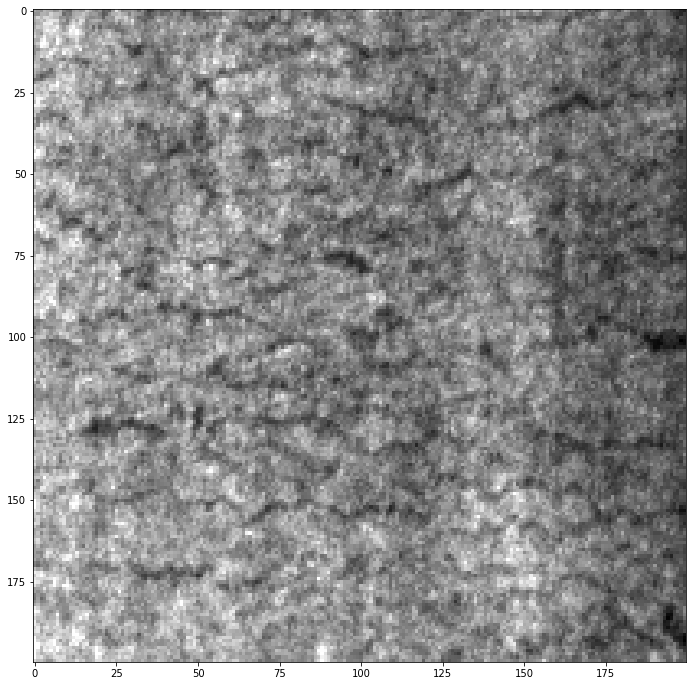

In [6]:
print('img (x_dim, y_dim) and type: ',img.shape, img.dtype)
plt.imshow(img, cmap='gray')

### 定義訓練資料

In [7]:
#欲分類的lable與數量
labels_name = os.listdir('./NEU-DET/train/images/')
num_classes = len(labels_name)

In [8]:
labels_name

['scratches',
 'inclusion',
 'rolled-in_scale',
 'crazing',
 'pitted_surface',
 'patches']

In [9]:
num_classes

6

In [10]:
#建立訓練資料所在的路徑位置與對應的label：(filelist, label)
#label為數字，0代表'NORMAL'、1代表'PNEUMONIA'
filelist = []
label = []
for i in labels_name:
    class_num = labels_name.index(i)
    pathfile = glob.glob('./NEU-DET/train/images/'+str(i)+'/*.jpg')
    
    for p in pathfile:
        filelist.append(p)
        label.append(class_num)

In [11]:
print('numbers of img:',len(filelist))

numbers of img: 1440


In [12]:
#影像縮放大小
desired_size = 200

In [13]:
#定義一個縮放影像(img)至指定大小(desired_size)的函數
#等比例縮小，其他地方補黑邊
def squared(img, desired_size):
    old_size = img.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img = cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_img

### 開始讀入影像

In [14]:
#先宣告一個指定大小的ndarray
all_data = np.zeros((len(filelist),desired_size,desired_size,3), dtype=np.float32)

In [15]:
#開始讀入影像
for i in tqdm(range(len(filelist))):
    img = cv2.imread(filelist[i], cv2.IMREAD_GRAYSCALE)
    new_img = squared(img, desired_size)

#進行正規化(normalization)，常用除255或z-score
    m = np.mean(new_img)
    s = np.std(new_img)
    t = (new_img-m)/s
#    t=new_img/255

#三個channel可給予不同的處理手法
    all_data[i,:,:,0]=t
    all_data[i,:,:,1]=t
    all_data[i,:,:,2]=t

100%|██████████| 1440/1440 [00:01<00:00, 1267.74it/s]


In [16]:
label=np.array(label)

### 模型匯入與切分資料集

In [17]:
#以test_size的比例分訓練集和驗證集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, Y_test = train_test_split(all_data, label, test_size=0.2, random_state=90)  

In [18]:
#對類別資料作One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(Y_test)

## 建立AI模型

In [19]:
#呼叫別人train好的模型，以resnet50為例
resmodel = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape = (desired_size, desired_size, 3))

In [20]:
#resmodel.summary()

In [21]:
#進階
#設定權重的凍結
# for layer in resmodel.layers:
#     print(layer.name)
#     layer.trainable=False

In [22]:
#撰寫模型
input_layer=tf.keras.layers.Input(shape=(desired_size,desired_size,3))

x=resmodel(input_layer)
x=tf.keras.layers.GlobalAveragePooling2D()(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(16, activation='relu')(x)
x=tf.keras.layers.Dropout(0.3)(x)

output_layer=tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [23]:
model=tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                32784     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102   

In [24]:
#data augmentation相關設定
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)  

## 開始訓練

In [25]:
#告訴AI學習的方式
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [26]:
#將訓練的模型置放於model_path下的model_name
model_name = 'NEU'

save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)

In [27]:
#設定模型存放方式(只存Validation表現最好的那一次)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

#設定多久沒進步就停下來
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1)

In [28]:
#開始訓練，順便把訓練過程存到model_history，方便後續畫圖
model_history=model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=70, 
                        steps_per_epoch=len(x_train)/32, validation_data=(x_test,y_test), callbacks=[earlystop, checkpoint])

Epoch 1/70
36/36 [==============================] - 34s 755ms/step - loss: 0.6336 - categorical_accuracy: 0.7630 - val_loss: 1.8930 - val_categorical_accuracy: 0.1840

Epoch 00001: val_loss improved from inf to 1.89300, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 2/70
36/36 [==============================] - 7s 197ms/step - loss: 0.2350 - categorical_accuracy: 0.9158 - val_loss: 2.3235 - val_categorical_accuracy: 0.1528

Epoch 00002: val_loss did not improve from 1.89300
Epoch 3/70
36/36 [==============================] - 7s 196ms/step - loss: 0.1954 - categorical_accuracy: 0.9236 - val_loss: 2.2203 - val_categorical_accuracy: 0.1736

Epoch 00003: val_loss did not improve from 1.89300
Epoch 4/70
36/36 [==============================] - 7s 197ms/step - loss: 0.1924 - categorical_accuracy: 0.9366 - val_loss: 2.3884 - val_categorical_accuracy: 0.2257

Epoch 00004: val_loss did not improve from 1.89300
Epoch 5/70
36/36 [==============================] - 7s 197ms/step - loss: 0.1229 - categorical_accuracy: 0.9575 - val_loss: 2.8487 - val_categorical_accuracy: 0.1597

Epoch 00005: val_loss did not improve from 1.89300
Epoch 6/70
36/36 [==============================] - 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 16/70
36/36 [==============================] - 7s 197ms/step - loss: 0.1079 - categorical_accuracy: 0.9601 - val_loss: 0.8289 - val_categorical_accuracy: 0.7049

Epoch 00016: val_loss improved from 1.08262 to 0.82892, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 17/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0921 - categorical_accuracy: 0.9731 - val_loss: 0.8936 - val_categorical_accuracy: 0.7500

Epoch 00017: val_loss did not improve from 0.82892
Epoch 18/70
36/36 [==============================] - 7s 195ms/step - loss: 0.0637 - categorical_accuracy: 0.9740 - val_loss: 0.3325 - val_categorical_accuracy: 0.8681

Epoch 00018: val_loss improved from 0.82892 to 0.33249, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 19/70
36/36 [==============================] - 7s 196ms/step - loss: 0.1031 - categorical_accuracy: 0.9748 - val_loss: 0.3243 - val_categorical_accuracy: 0.9167

Epoch 00019: val_loss improved from 0.33249 to 0.32430, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 20/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0810 - categorical_accuracy: 0.9696 - val_loss: 0.1286 - val_categorical_accuracy: 0.9618

Epoch 00020: val_loss improved from 0.32430 to 0.12855, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 21/70
36/36 [==============================] - 7s 196ms/step - loss: 0.0926 - categorical_accuracy: 0.9592 - val_loss: 0.0806 - val_categorical_accuracy: 0.9722

Epoch 00021: val_loss improved from 0.12855 to 0.08060, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 22/70
36/36 [==============================] - 7s 196ms/step - loss: 0.0755 - categorical_accuracy: 0.9740 - val_loss: 0.5955 - val_categorical_accuracy: 0.9028

Epoch 00022: val_loss did not improve from 0.08060
Epoch 23/70
36/36 [==============================] - 7s 196ms/step - loss: 0.0609 - categorical_accuracy: 0.9766 - val_loss: 0.2976 - val_categorical_accuracy: 0.9444

Epoch 00023: val_loss did not improve from 0.08060
Epoch 24/70
36/36 [==============================] - 7s 194ms/step - loss: 0.0577 - categorical_accuracy: 0.9740 - val_loss: 0.0984 - val_categorical_accuracy: 0.9757

Epoch 00024: val_loss did not improve from 0.08060
Epoch 25/70
36/36 [==============================] - 7s 194ms/step - loss: 0.0446 - categorical_accuracy: 0.9826 - val_loss: 0.0121 - val_categorical_accuracy: 0.9965

Epoch 00025: val_loss improved from 0.08060 to 0.01208, saving model to /home/robust5566/saved_mode

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 26/70
36/36 [==============================] - 7s 193ms/step - loss: 0.0458 - categorical_accuracy: 0.9800 - val_loss: 0.0085 - val_categorical_accuracy: 1.0000

Epoch 00026: val_loss improved from 0.01208 to 0.00847, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 27/70
36/36 [==============================] - 7s 195ms/step - loss: 0.1048 - categorical_accuracy: 0.9714 - val_loss: 0.3441 - val_categorical_accuracy: 0.9618

Epoch 00027: val_loss did not improve from 0.00847
Epoch 28/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0489 - categorical_accuracy: 0.9870 - val_loss: 0.0032 - val_categorical_accuracy: 1.0000

Epoch 00028: val_loss improved from 0.00847 to 0.00315, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 29/70
36/36 [==============================] - 7s 196ms/step - loss: 0.0628 - categorical_accuracy: 0.9792 - val_loss: 0.0046 - val_categorical_accuracy: 1.0000

Epoch 00029: val_loss did not improve from 0.00315
Epoch 30/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0494 - categorical_accuracy: 0.9809 - val_loss: 0.0039 - val_categorical_accuracy: 1.0000

Epoch 00030: val_loss did not improve from 0.00315
Epoch 31/70
36/36 [==============================] - 7s 195ms/step - loss: 0.0598 - categorical_accuracy: 0.9809 - val_loss: 0.0091 - val_categorical_accuracy: 1.0000

Epoch 00031: val_loss did not improve from 0.00315
Epoch 32/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0568 - categorical_accuracy: 0.9835 - val_loss: 0.0024 - val_categorical_accuracy: 1.0000

Epoch 00032: val_loss improved from 0.00315 to 0.00245, saving model to /home/robust5566/saved_mode

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 33/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0585 - categorical_accuracy: 0.9809 - val_loss: 0.0254 - val_categorical_accuracy: 0.9965

Epoch 00033: val_loss did not improve from 0.00245
Epoch 34/70
36/36 [==============================] - 7s 196ms/step - loss: 0.1156 - categorical_accuracy: 0.9748 - val_loss: 0.1443 - val_categorical_accuracy: 0.9444

Epoch 00034: val_loss did not improve from 0.00245
Epoch 35/70
36/36 [==============================] - 7s 196ms/step - loss: 0.0614 - categorical_accuracy: 0.9809 - val_loss: 0.0567 - val_categorical_accuracy: 0.9792

Epoch 00035: val_loss did not improve from 0.00245
Epoch 36/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0746 - categorical_accuracy: 0.9766 - val_loss: 0.1011 - val_categorical_accuracy: 0.9757

Epoch 00036: val_loss did not improve from 0.00245
Epoch 37/70
36/36 [=============================

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 43/70
36/36 [==============================] - 7s 198ms/step - loss: 0.0414 - categorical_accuracy: 0.9878 - val_loss: 6.7232e-04 - val_categorical_accuracy: 1.0000

Epoch 00043: val_loss improved from 0.00097 to 0.00067, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 44/70
36/36 [==============================] - 7s 196ms/step - loss: 0.0571 - categorical_accuracy: 0.9844 - val_loss: 5.6376e-04 - val_categorical_accuracy: 1.0000

Epoch 00044: val_loss improved from 0.00067 to 0.00056, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 45/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0498 - categorical_accuracy: 0.9835 - val_loss: 0.0023 - val_categorical_accuracy: 1.0000

Epoch 00045: val_loss did not improve from 0.00056
Epoch 46/70
36/36 [==============================] - 7s 196ms/step - loss: 0.0682 - categorical_accuracy: 0.9783 - val_loss: 0.0335 - val_categorical_accuracy: 0.9861

Epoch 00046: val_loss did not improve from 0.00056
Epoch 47/70
36/36 [==============================] - 7s 198ms/step - loss: 0.0493 - categorical_accuracy: 0.9800 - val_loss: 9.8221e-04 - val_categorical_accuracy: 1.0000

Epoch 00047: val_loss did not improve from 0.00056
Epoch 48/70
36/36 [==============================] - 7s 198ms/step - loss: 0.0442 - categorical_accuracy: 0.9826 - val_loss: 0.0020 - val_categorical_accuracy: 1.0000

Epoch 00048: val_loss did not improve from 0.00056
Epoch 49/70
36/36 [=========================

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 51/70
36/36 [==============================] - 7s 198ms/step - loss: 0.0355 - categorical_accuracy: 0.9887 - val_loss: 2.1672e-04 - val_categorical_accuracy: 1.0000

Epoch 00051: val_loss did not improve from 0.00020
Epoch 52/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0563 - categorical_accuracy: 0.9835 - val_loss: 6.7830e-05 - val_categorical_accuracy: 1.0000

Epoch 00052: val_loss improved from 0.00020 to 0.00007, saving model to /home/robust5566/saved_models/NEU


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/robust5566/saved_models/NEU/assets
Epoch 53/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0435 - categorical_accuracy: 0.9852 - val_loss: 9.6299e-04 - val_categorical_accuracy: 1.0000

Epoch 00053: val_loss did not improve from 0.00007
Epoch 54/70
36/36 [==============================] - 7s 197ms/step - loss: 0.1063 - categorical_accuracy: 0.9818 - val_loss: 0.0975 - val_categorical_accuracy: 0.9757

Epoch 00054: val_loss did not improve from 0.00007
Epoch 55/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0605 - categorical_accuracy: 0.9792 - val_loss: 0.0023 - val_categorical_accuracy: 1.0000

Epoch 00055: val_loss did not improve from 0.00007
Epoch 56/70
36/36 [==============================] - 7s 197ms/step - loss: 0.0537 - categorical_accuracy: 0.9818 - val_loss: 0.0213 - val_categorical_accuracy: 0.9896

Epoch 00056: val_loss did not improve from 0.00007
Epoch 57/70
36/36 [=========================

## 畫圖

In [29]:
model_history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [30]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

training_acc = model_history.history['categorical_accuracy']
val_acc = model_history.history['val_categorical_accuracy']

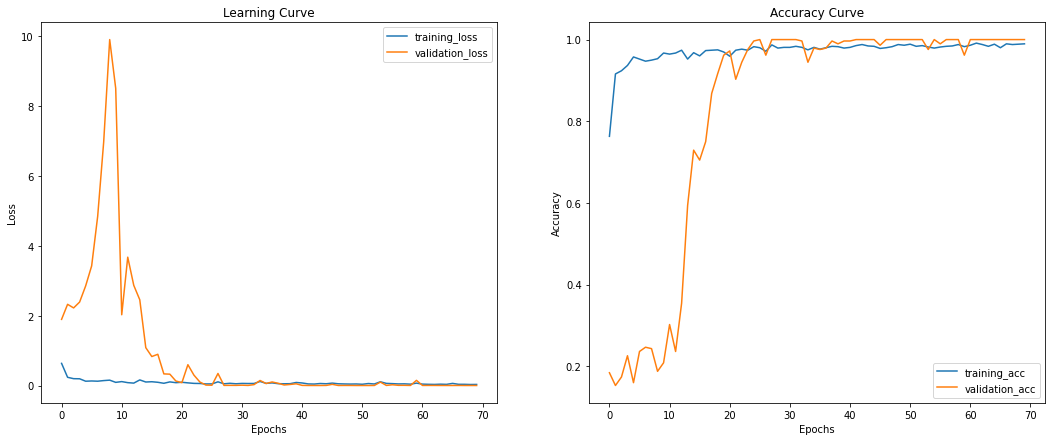

In [31]:
#畫圖
plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.legend(loc='upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc='best')

plt.show()

## 作預測

In [32]:
#載入訓練好的模型
model = tf.keras.models.load_model(model_path)

In [33]:
#使用AI模型作預測
pred=model.predict(x_test)

In [34]:
#將預測的機率轉換成類別
ans=np.argmax(pred, axis=-1)

In [35]:
#畫出混淆矩陣
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(Y_test, ans)
print(cf_matrix)

[[49  0  0  0  0  0]
 [ 0 43  0  0  0  0]
 [ 0  0 44  0  0  0]
 [ 0  0  0 46  0  0]
 [ 0  0  0  0 60  0]
 [ 0  0  0  0  0 46]]


<AxesSubplot:>

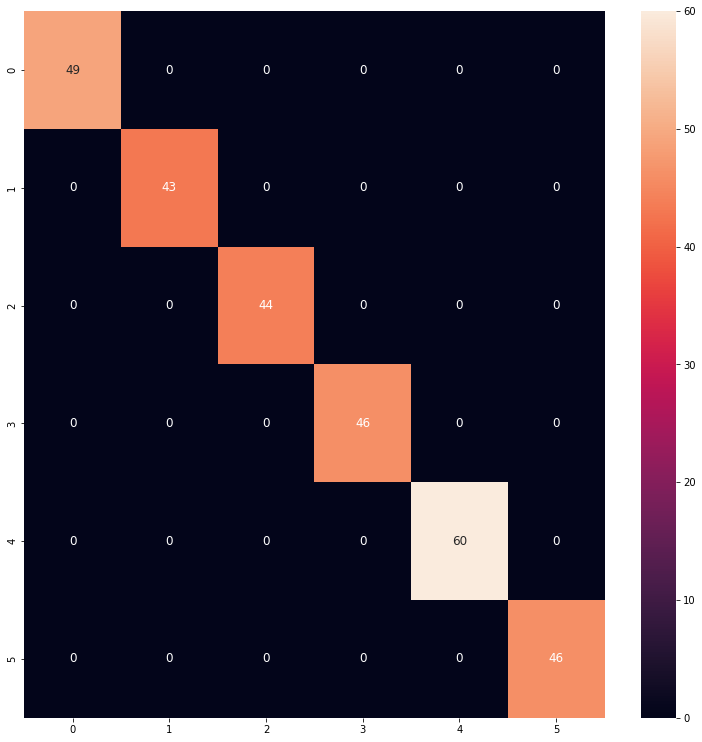

In [36]:
#對混淆矩陣畫圖
import seaborn as sns
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(cf_matrix, fmt='g', annot=True, annot_kws={"size":12})

In [37]:
#計算統計指標
from sklearn.metrics import classification_report
report = classification_report(Y_test, ans)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        46
           4       1.00      1.00      1.00        60
           5       1.00      1.00      1.00        46

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288

